In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [2]:
import os
os.chdir('/gdrive/My Drive/environment/Deep Learning/CNN Studies/Alzheimer/data')

In [3]:
import pickle

In [4]:
X_ = open('X.pickle', 'rb')
y_ = open('y.pickle', 'rb')

X = pickle.load(X_)
y = pickle.load(y_)
X_.close()
y_.close()

### Gerekli birkaç kütüphanenin import edilmesi

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Verilerin karıştırılıp Standardize edilmesi

In [6]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)
X = np.array(X)
y = np.array(y)

mean = np.mean(X)
std = np.std(X)

X = ((X - mean) / std).astype(np.float32)

In [7]:
print(X.shape)
print(y.shape)

(5121, 100, 100, 3)
(5121,)


In [8]:
y

array([0, 2, 2, ..., 2, 2, 2])

### Test - Train

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
input_train, input_test, target_train, target_test = train_test_split(X, y, test_size=.2, random_state=0)

In [11]:
target_test

array([3, 0, 0, ..., 2, 0, 3])

In [12]:
target_train

array([2, 2, 3, ..., 2, 1, 2])

# Model Basic

In [13]:
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.models import Sequential

In [14]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         5

In [15]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adamax',
            metrics=['acc'])

In [16]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_basic.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=16, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
205/205 [==============================] - 4s 19ms/step - loss: 1.1390 - acc: 0.5693 - val_loss: 1.0008 - val_acc: 0.4963
Epoch 2/50
205/205 [==============================] - 4s 17ms/step - loss: 0.6816 - acc: 0.6938 - val_loss: 0.8973 - val_acc: 0.5598
Epoch 3/50
205/205 [==============================] - 4s 17ms/step - loss: 0.4333 - acc: 0.8300 - val_loss: 0.4672 - val_acc: 0.8427
Epoch 4/50
205/205 [==============================] - 4s 17ms/step - loss: 0.2089 - acc: 0.9353 - val_loss: 1.5506 - val_acc: 0.5610
Epoch 5/50
205/205 [==============================] - 4s 18ms/step - loss: 0.1025 - acc: 0.9695 - val_loss: 0.4423 - val_acc: 0.8232
Epoch 6/50
205/205 [==============================] - 4s 17ms/step - loss: 0.0438 - acc: 0.9896 - val_loss: 0.2692 - val_acc: 0.8939
Epoch 7/50
205/205 [==============================] - 4s 17ms/step - loss: 0.0185 - acc: 0.9966 - val_loss: 0.5725 - val_acc: 0.8220
Epoch 8/50
205/205 [==============================] - 4s 17ms/step - 

In [17]:
model.evaluate(input_test, target_test)

33/33 [==============================] - 0s 9ms/step - loss: 0.1063 - acc: 0.9737


[0.10627388954162598, 0.973658561706543]

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [19]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

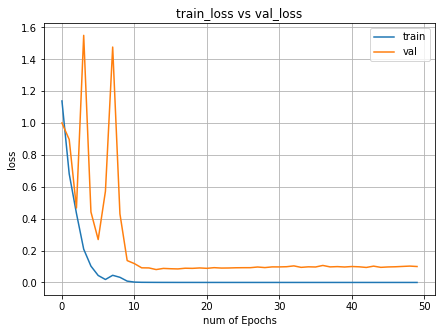

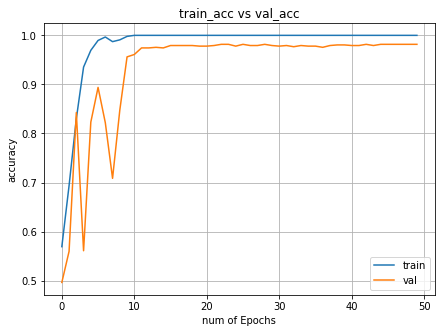

In [20]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

**Confusion Matrix**

In [21]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
target_pred = model.predict_classes([input_test])
cm = confusion_matrix(target_test, target_pred)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
33/33 [==============================] - 0s 7ms/step - loss: 0.1063 - acc: 0.9737


Model Test Başarımı:  [0.10627388954162598, 0.973658561706543]


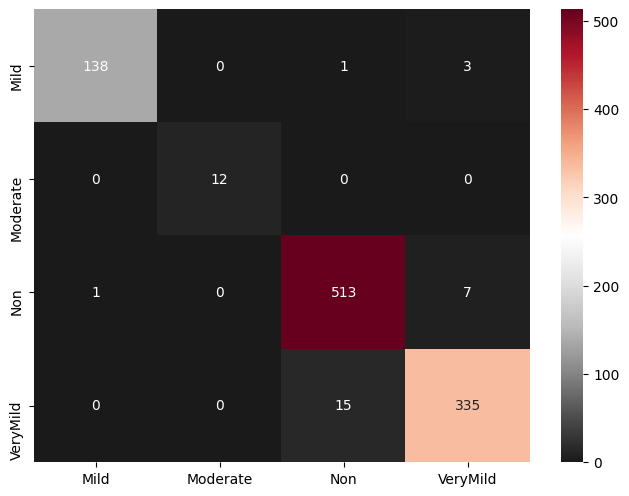

In [22]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

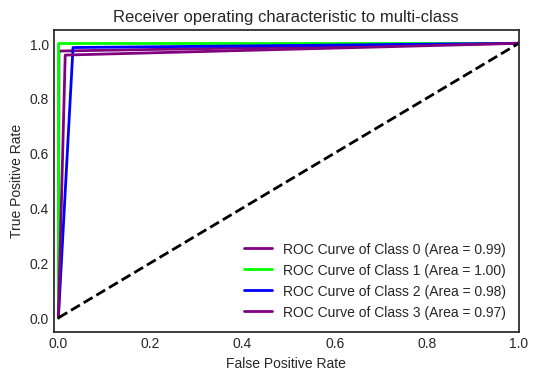

<Figure size 432x288 with 0 Axes>

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(target_pred, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()
plt.savefig("basic_roc.png")

In [24]:
model.save('best_model.h5')

# Model Branched

In [25]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from keras.activations import relu, softmax, sigmoid
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.applications import ResNet50, VGG16, VGG19
from keras import Input, Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

In [26]:
visible = Input(shape=(100, 100, 3))


conv1_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

conv1_2 = Conv2D(128, kernel_size=3, activation='relu')(pool1_1)
pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv1_3 = Conv2D(128, kernel_size=3, activation='relu')(pool1_2)
pool1_3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)

conv1_4 = Conv2D(256, kernel_size=3, activation='relu')(pool1_3)
pool1_4 = MaxPooling2D(pool_size=(2, 2))(conv1_4)
batch_norm_1 = BatchNormalization()(pool1_4)

flat1 = Flatten()(batch_norm_1)



conv2_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

conv2_2 = Conv2D(128, kernel_size=3, activation='relu')(pool2_1)
pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv2_3 = Conv2D(128, kernel_size=3, activation='relu')(pool2_2)
pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)

conv2_4 = Conv2D(256, kernel_size=3, activation='relu')(pool2_3)
pool2_4 = MaxPooling2D(pool_size=(2, 2))(conv2_4)
batch_norm_2 = BatchNormalization()(pool2_4)

flat2 = Flatten()(batch_norm_2)



conv3_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool3_1 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

conv3_2 = Conv2D(128, kernel_size=3, activation='relu')(pool3_1)
pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv3_3 = Conv2D(128, kernel_size=3, activation='relu')(pool3_2)
pool3_3 = MaxPooling2D(pool_size=(2, 2))(conv3_3)

conv3_4 = Conv2D(256, kernel_size=3, activation='relu')(pool3_3)
pool3_4 = MaxPooling2D(pool_size=(2, 2))(conv3_4)
batch_norm_3 = BatchNormalization()(pool3_4)

flat3 = Flatten()(batch_norm_3)



conv4_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

conv4_2 = Conv2D(128, kernel_size=3, activation='relu')(pool4_1)
pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_2)

conv4_3 = Conv2D(128, kernel_size=3, activation='relu')(pool4_2)
pool4_3 = MaxPooling2D(pool_size=(2, 2))(conv4_3)

conv4_4 = Conv2D(256, kernel_size=3, activation='relu')(pool4_3)
pool4_4 = MaxPooling2D(pool_size=(2, 2))(conv4_4)
batch_norm_4 = BatchNormalization()(pool4_4)

flat4 = Flatten()(batch_norm_4)

# merge
merge = concatenate([flat1, flat2, flat3, flat4])
dropout_layer_1 = Dropout(0.25)(merge)
hidden1 = Dense(512, activation='relu')(dropout_layer_1)
# Çıkış Katmanı
dropout_layer_3 = Dropout(0.5)(hidden1)
output = Dense(4, activation='softmax')(dropout_layer_3)
model = Model(inputs = visible, outputs = output)

# Modeli Özetle
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 98, 98, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 98, 98, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 98, 98, 64)   1792        input_1[0][0]                    
_______________________________________________________________________________________

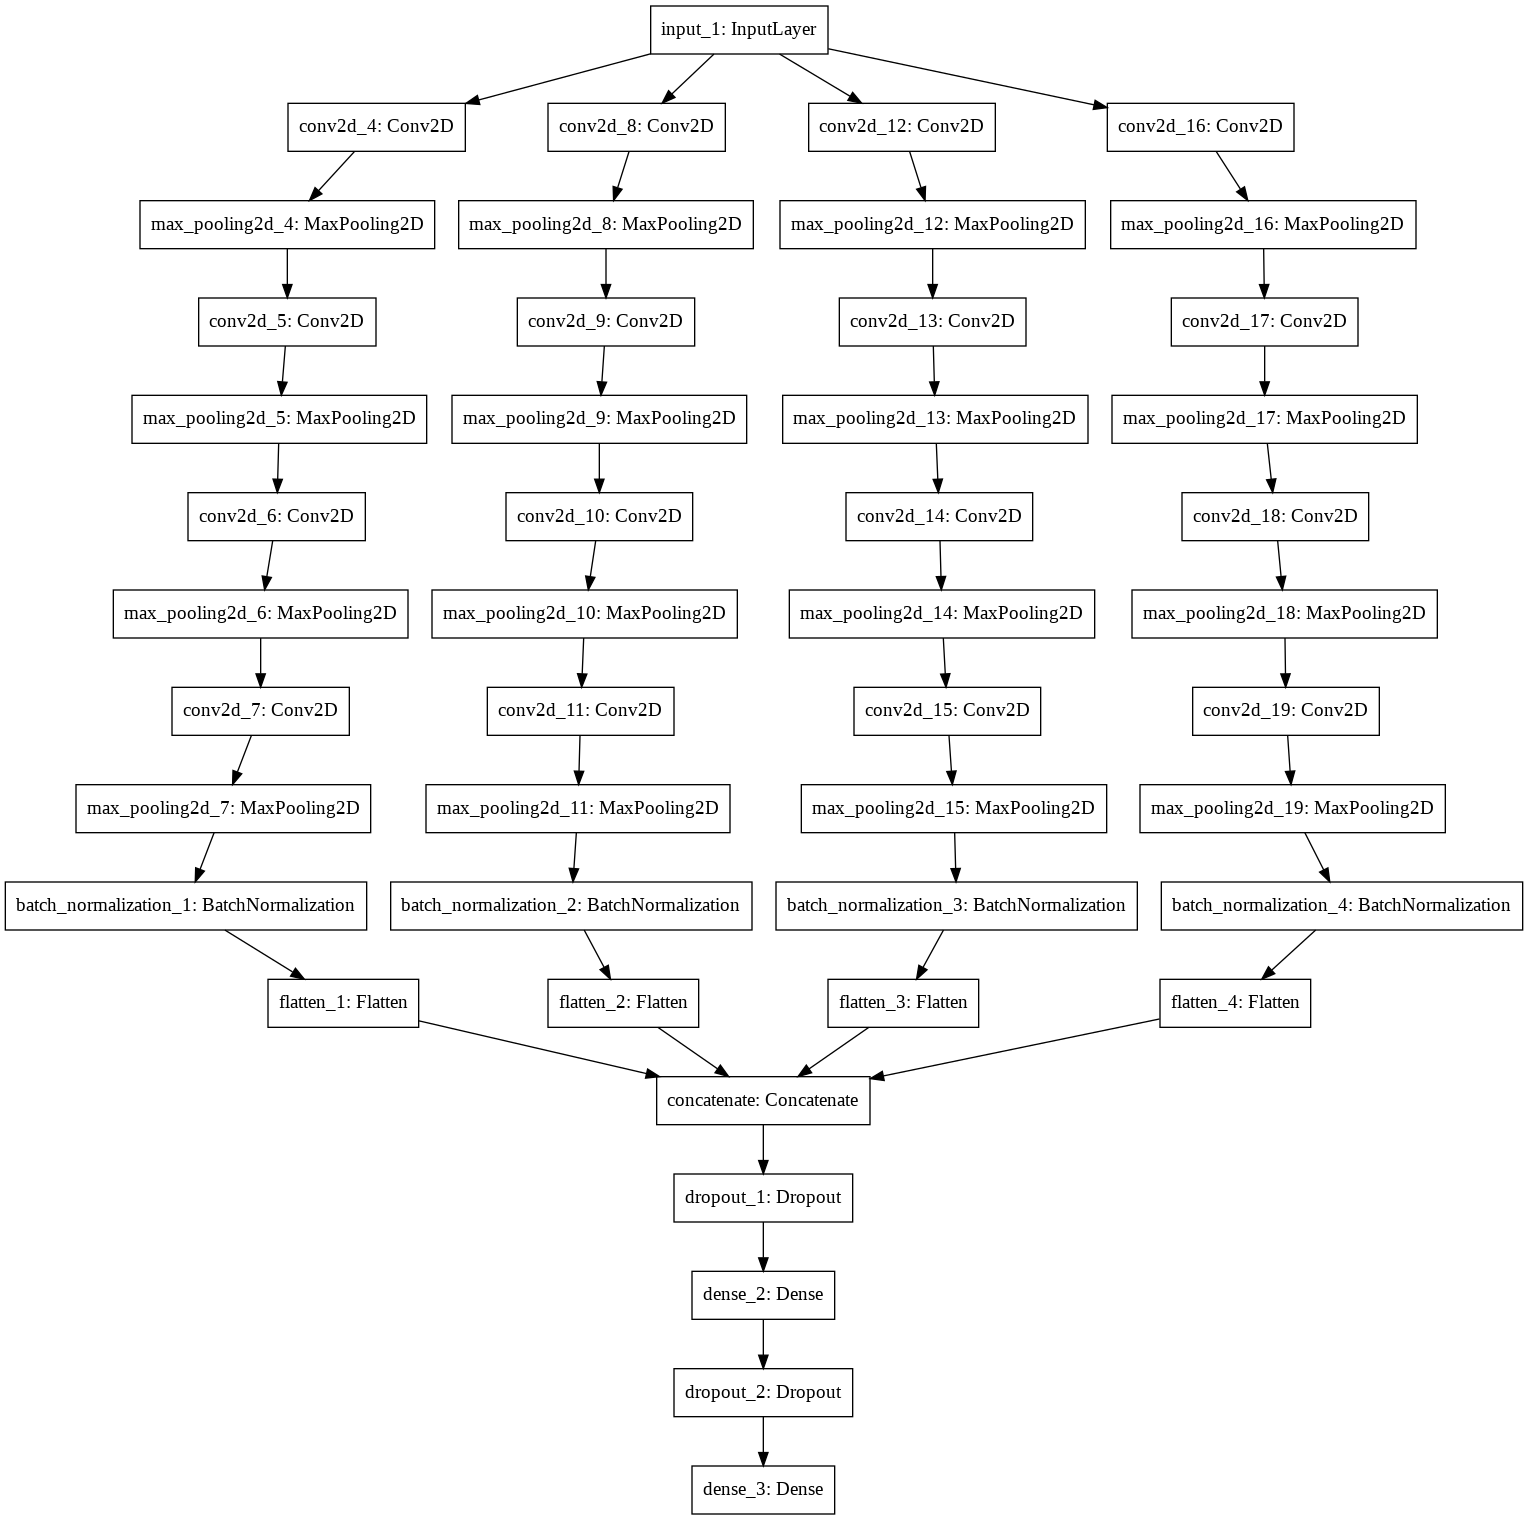

In [27]:
import os
os.chdir('/gdrive/My Drive/environment/Deep Learning/CNN Studies/Alzheimer/data')
plot_model(model, to_file='model_basic_branched.png')

In [28]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adamax',
            metrics=['acc'])

In [29]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_branched.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=16, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
205/205 [==============================] - 9s 42ms/step - loss: 1.3445 - acc: 0.5143 - val_loss: 1.2055 - val_acc: 0.4841
Epoch 2/50
205/205 [==============================] - 8s 41ms/step - loss: 0.8878 - acc: 0.5757 - val_loss: 0.8533 - val_acc: 0.5963
Epoch 3/50
205/205 [==============================] - 9s 42ms/step - loss: 0.8126 - acc: 0.6169 - val_loss: 0.7922 - val_acc: 0.6549
Epoch 4/50
205/205 [==============================] - 9s 42ms/step - loss: 0.7336 - acc: 0.6612 - val_loss: 1.3134 - val_acc: 0.5549
Epoch 5/50
205/205 [==============================] - 9s 41ms/step - loss: 0.6252 - acc: 0.7338 - val_loss: 0.8604 - val_acc: 0.6134
Epoch 6/50
205/205 [==============================] - 8s 41ms/step - loss: 0.4617 - acc: 0.8065 - val_loss: 0.5775 - val_acc: 0.7500
Epoch 7/50
205/205 [==============================] - 8s 41ms/step - loss: 0.2908 - acc: 0.8910 - val_loss: 0.3884 - val_acc: 0.8341
Epoch 8/50
205/205 [==============================] - 8s 41ms/step - 

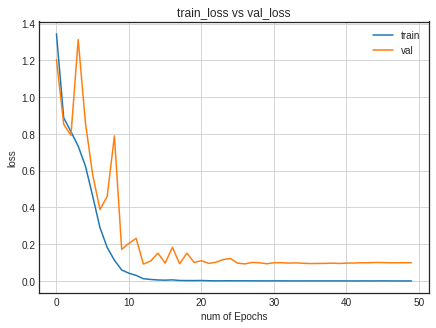

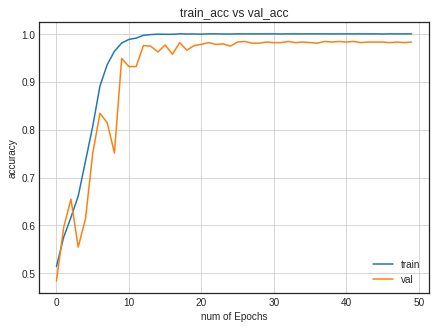

In [30]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc, train_loss)
plt.plot(xc, val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
target_pred = model.predict([input_test])
preds = np.argmax(target_pred, axis=1)
cm = confusion_matrix(target_test, preds)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

33/33 [==============================] - 1s 20ms/step - loss: 0.0699 - acc: 0.9844


Model Test Başarımı:  [0.06993673741817474, 0.9843902587890625]


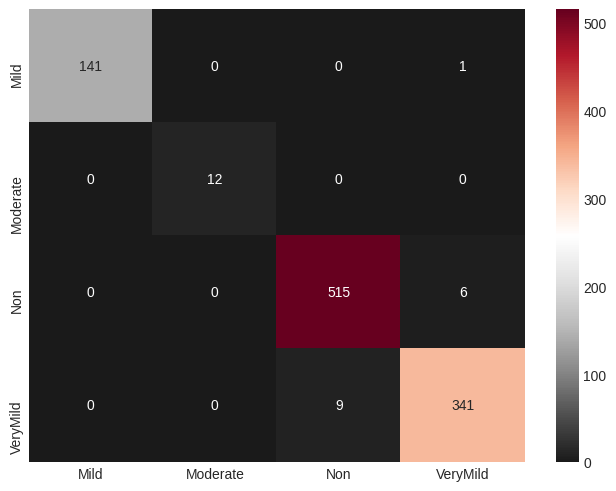

In [32]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

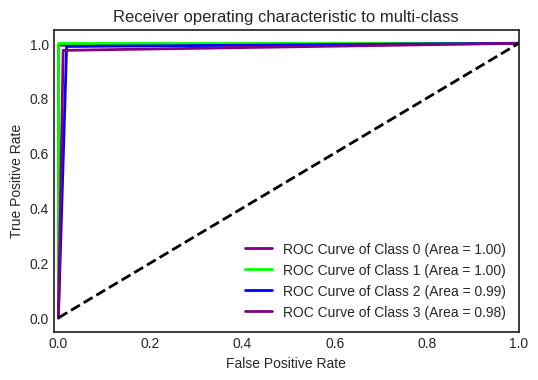

<Figure size 432x288 with 0 Axes>

In [33]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(preds, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()
plt.savefig("basic_roc.png")

In [34]:
model.save('best_model.h5')

# ResNet50

In [35]:
from keras.applications import ResNet50

In [36]:
conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32768)             131072    
_________________________________________________________________
dropout_3 (Dropout)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)              

In [37]:
model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [38]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_basic.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=16, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
205/205 [==============================] - 6s 31ms/step - loss: 1.5579 - acc: 0.5137 - val_loss: 0.8422 - val_acc: 0.6512
Epoch 2/50
205/205 [==============================] - 5s 26ms/step - loss: 0.8738 - acc: 0.6700 - val_loss: 0.6396 - val_acc: 0.7585
Epoch 3/50
205/205 [==============================] - 5s 26ms/step - loss: 0.6699 - acc: 0.7378 - val_loss: 0.5110 - val_acc: 0.8183
Epoch 4/50
205/205 [==============================] - 5s 26ms/step - loss: 0.5710 - acc: 0.7778 - val_loss: 0.4454 - val_acc: 0.8293
Epoch 5/50
205/205 [==============================] - 5s 26ms/step - loss: 0.5023 - acc: 0.8040 - val_loss: 0.4268 - val_acc: 0.8439
Epoch 6/50
205/205 [==============================] - 5s 26ms/step - loss: 0.3962 - acc: 0.8465 - val_loss: 0.3701 - val_acc: 0.8756
Epoch 7/50
205/205 [==============================] - 5s 26ms/step - loss: 0.3523 - acc: 0.8614 - val_loss: 0.3724 - val_acc: 0.8720
Epoch 8/50
205/205 [==============================] - 5s 26ms/step - 

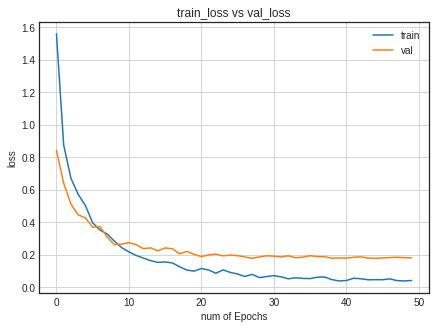

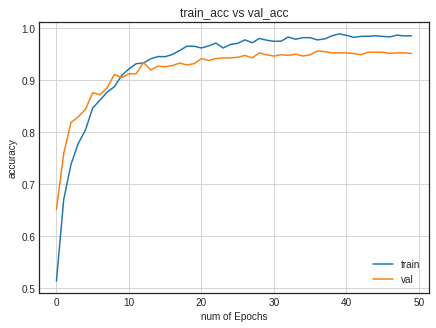

In [39]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

In [40]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

target_pred = model.predict(input_test)
target_pred = np.argmax(target_pred, axis=1)

In [41]:
cm = confusion_matrix(target_test, target_pred)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

33/33 [==============================] - 1s 27ms/step - loss: 0.1354 - acc: 0.9571


Model Test Başarımı:  [0.135377898812294, 0.9570731520652771]


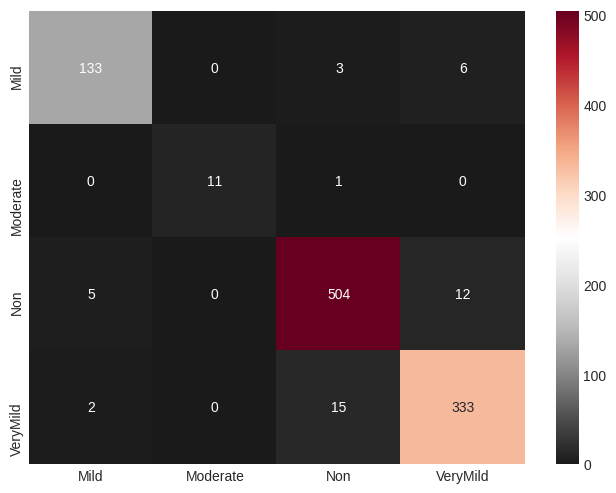

In [42]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

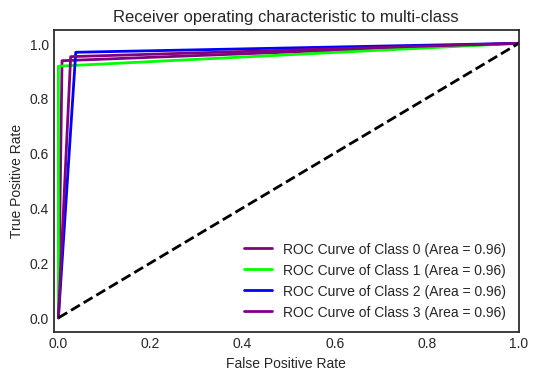

<Figure size 432x288 with 0 Axes>

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(target_pred, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()
plt.savefig("resnet50_roc.png")

In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

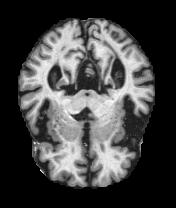

In [45]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

model_builder = keras.applications.resnet50.ResNet50

img_size = (100, 100)

preprocess_input = preprocess_input
decode_predictions = decode_predictions



last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]


img_path = "./verymildDem23.jpg"

display(Image(img_path))

In [46]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

model = model_builder(weights="imagenet")

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)


Predicted: [('n04192698', 'shield', 0.74995714)]


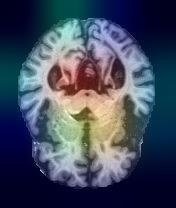

In [47]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

save_path = "sample1.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

# **CLAHE**

In [91]:
X_ = open('X_clahe.pickle', 'rb')
y_ = open('y_clahe.pickle', 'rb')

X = pickle.load(X_)
y = pickle.load(y_)
X_.close()
y_.close()

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:
from sklearn.utils import shuffle
X, y = shuffle(X, y, random_state=0)
X = np.array(X)
y = np.array(y)

mean = np.mean(X)
std = np.std(X)

X = ((X - mean) / std).astype(np.float32)

In [94]:
from sklearn.model_selection import train_test_split

In [95]:
input_train, input_test, target_train, target_test = train_test_split(X, y, test_size=.2, random_state=0)

### **Model Basic**

In [96]:
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from keras.models import Sequential

In [97]:
model = Sequential()

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 128)       73856     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 128)       0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 256)       295168    
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 256)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 256)      

In [98]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adamax',
            metrics=['acc'])

In [99]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_basic_clahe.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=32, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
103/103 [==============================] - 6s 62ms/step - loss: 1.5717 - acc: 0.5461 - val_loss: 1.0466 - val_acc: 0.4573
Epoch 2/50
103/103 [==============================] - 6s 61ms/step - loss: 0.7500 - acc: 0.6590 - val_loss: 1.4830 - val_acc: 0.1646
Epoch 3/50
103/103 [==============================] - 6s 62ms/step - loss: 0.6194 - acc: 0.7277 - val_loss: 1.3561 - val_acc: 0.4122
Epoch 4/50
103/103 [==============================] - 6s 62ms/step - loss: 0.3596 - acc: 0.8687 - val_loss: 0.8254 - val_acc: 0.6354
Epoch 5/50
103/103 [==============================] - 6s 61ms/step - loss: 0.1919 - acc: 0.9441 - val_loss: 2.0081 - val_acc: 0.5305
Epoch 6/50
103/103 [==============================] - 6s 61ms/step - loss: 0.1009 - acc: 0.9750 - val_loss: 0.9256 - val_acc: 0.7415
Epoch 7/50
103/103 [==============================] - 6s 61ms/step - loss: 0.0390 - acc: 0.9957 - val_loss: 1.0418 - val_acc: 0.6793
Epoch 8/50
103/103 [==============================] - 6s 60ms/step - 

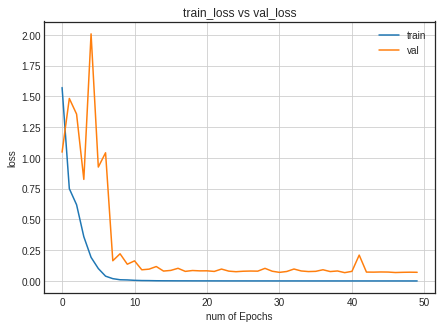

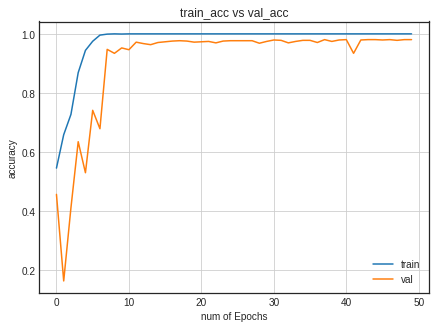

In [100]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
target_pred = model.predict_classes([input_test])
cm = confusion_matrix(target_test, target_pred)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

33/33 [==============================] - 0s 15ms/step - loss: 0.0786 - acc: 0.9766


Model Test Başarımı:  [0.07860857248306274, 0.9765853881835938]


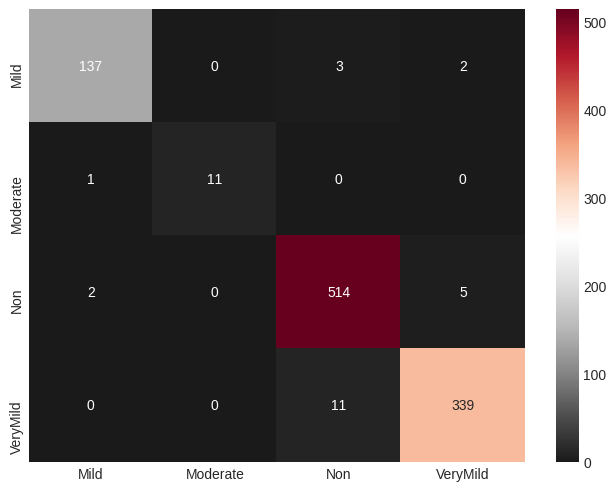

In [102]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

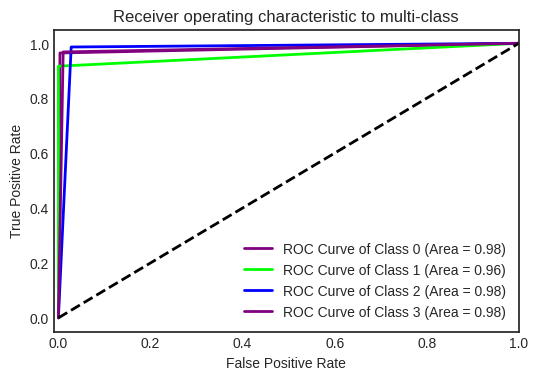

In [103]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(target_pred, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()

### **Model Branched**

In [104]:
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from keras.activations import relu, softmax, sigmoid
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.applications import ResNet50, VGG16, VGG19
from keras import Input, Model
from keras.utils import plot_model
from keras.layers.merge import concatenate

In [105]:
visible = Input(shape=(150, 150, 3))


conv1_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool1_1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)

conv1_2 = Conv2D(128, kernel_size=3, activation='relu')(pool1_1)
pool1_2 = MaxPooling2D(pool_size=(2, 2))(conv1_2)

conv1_3 = Conv2D(128, kernel_size=3, activation='relu')(pool1_2)
pool1_3 = MaxPooling2D(pool_size=(2, 2))(conv1_3)

conv1_4 = Conv2D(256, kernel_size=3, activation='relu')(pool1_3)
pool1_4 = MaxPooling2D(pool_size=(2, 2))(conv1_4)
batch_norm_1 = BatchNormalization()(pool1_4)

flat1 = Flatten()(batch_norm_1)



conv2_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool2_1 = MaxPooling2D(pool_size=(2, 2))(conv2_1)

conv2_2 = Conv2D(128, kernel_size=3, activation='relu')(pool2_1)
pool2_2 = MaxPooling2D(pool_size=(2, 2))(conv2_2)

conv2_3 = Conv2D(128, kernel_size=3, activation='relu')(pool2_2)
pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_3)

conv2_4 = Conv2D(256, kernel_size=3, activation='relu')(pool2_3)
pool2_4 = MaxPooling2D(pool_size=(2, 2))(conv2_4)
batch_norm_2 = BatchNormalization()(pool2_4)

flat2 = Flatten()(batch_norm_2)



conv3_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool3_1 = MaxPooling2D(pool_size=(2, 2))(conv3_1)

conv3_2 = Conv2D(128, kernel_size=3, activation='relu')(pool3_1)
pool3_2 = MaxPooling2D(pool_size=(2, 2))(conv3_2)

conv3_3 = Conv2D(128, kernel_size=3, activation='relu')(pool3_2)
pool3_3 = MaxPooling2D(pool_size=(2, 2))(conv3_3)

conv3_4 = Conv2D(256, kernel_size=3, activation='relu')(pool3_3)
pool3_4 = MaxPooling2D(pool_size=(2, 2))(conv3_4)
batch_norm_3 = BatchNormalization()(pool3_4)

flat3 = Flatten()(batch_norm_3)



conv4_1 = Conv2D(64, kernel_size=3, activation='relu')(visible)
pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_1)

conv4_2 = Conv2D(128, kernel_size=3, activation='relu')(pool4_1)
pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_2)

conv4_3 = Conv2D(128, kernel_size=3, activation='relu')(pool4_2)
pool4_3 = MaxPooling2D(pool_size=(2, 2))(conv4_3)

conv4_4 = Conv2D(256, kernel_size=3, activation='relu')(pool4_3)
pool4_4 = MaxPooling2D(pool_size=(2, 2))(conv4_4)
batch_norm_4 = BatchNormalization()(pool4_4)

flat4 = Flatten()(batch_norm_4)

# merge
merge = concatenate([flat1, flat2, flat3, flat4])
dropout_layer_1 = Dropout(0.25)(merge)
hidden1 = Dense(512, activation='relu')(dropout_layer_1)
# Çıkış Katmanı
dropout_layer_3 = Dropout(0.5)(hidden1)
output = Dense(4, activation='softmax')(dropout_layer_3)
model = Model(inputs = visible, outputs = output)

In [106]:
model.compile(loss='sparse_categorical_crossentropy',
            optimizer='adamax',
            metrics=['acc'])

In [107]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_branched_clahe.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=32, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
103/103 [==============================] - 17s 163ms/step - loss: 1.9812 - acc: 0.5076 - val_loss: 1.0714 - val_acc: 0.4610
Epoch 2/50
103/103 [==============================] - 17s 161ms/step - loss: 0.8994 - acc: 0.5568 - val_loss: 1.1233 - val_acc: 0.5756
Epoch 3/50
103/103 [==============================] - 17s 160ms/step - loss: 0.8568 - acc: 0.5794 - val_loss: 1.0119 - val_acc: 0.5683
Epoch 4/50
103/103 [==============================] - 16s 160ms/step - loss: 0.8041 - acc: 0.5849 - val_loss: 0.9609 - val_acc: 0.5902
Epoch 5/50
103/103 [==============================] - 16s 160ms/step - loss: 0.7420 - acc: 0.6303 - val_loss: 0.8412 - val_acc: 0.6366
Epoch 6/50
103/103 [==============================] - 16s 160ms/step - loss: 0.6741 - acc: 0.6737 - val_loss: 0.8555 - val_acc: 0.5707
Epoch 7/50
103/103 [==============================] - 17s 160ms/step - loss: 0.6125 - acc: 0.7247 - val_loss: 0.9235 - val_acc: 0.5793
Epoch 8/50
103/103 [==============================] - 1

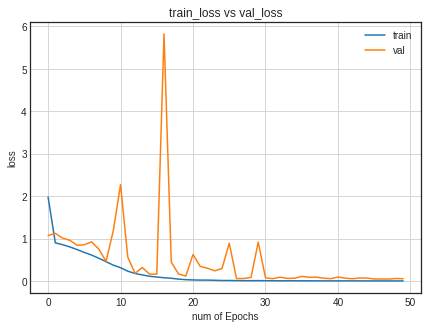

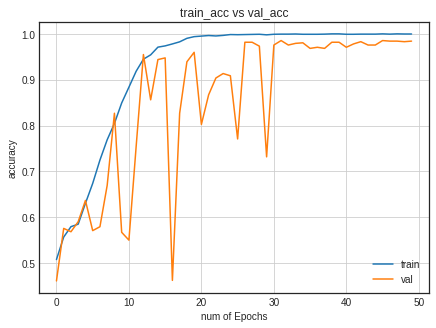

In [108]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

In [109]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
target_pred = model.predict([input_test])
preds = np.argmax(target_pred, axis=1)
cm = confusion_matrix(target_test, preds)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

33/33 [==============================] - 1s 38ms/step - loss: 0.0579 - acc: 0.9815


Model Test Başarımı:  [0.05788740515708923, 0.9814634323120117]


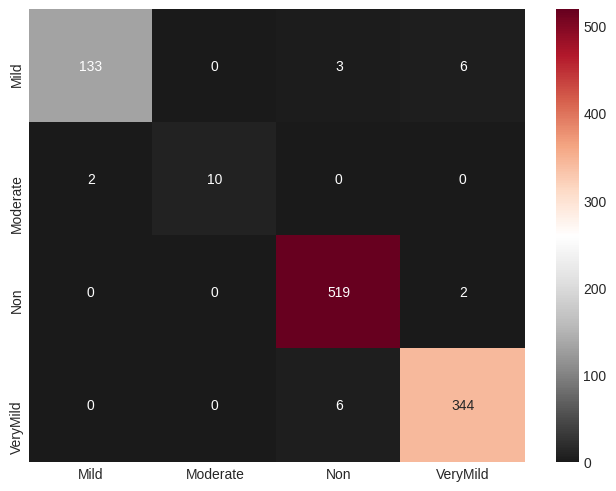

In [110]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

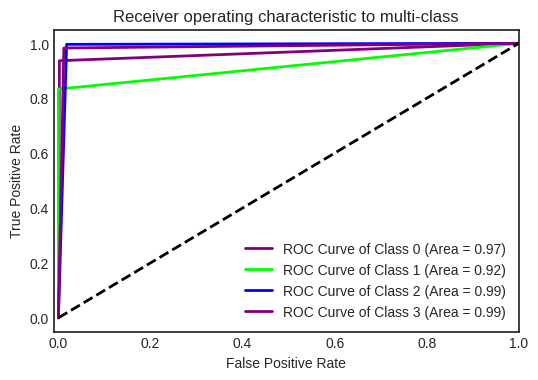

In [111]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(preds, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()

In [112]:
model.save('best.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


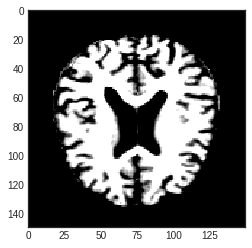

In [113]:
from matplotlib import pyplot as plt
plt.imshow(input_test[7], interpolation='nearest')
plt.show()

In [114]:
from keras.models import load_model
model = load_model('best.h5')

In [115]:
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 148, 148, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 148, 148, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 148, 148, 64) 1792        input_10[0][0]                   
______________________________________________________________________________________

### ResNet50

In [116]:
from keras.applications import ResNet50

In [117]:
conv_base = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

conv_base.trainable = False

model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_18 (Flatten)         (None, 51200)             0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 51200)             204800    
_________________________________________________________________
dropout_15 (Dropout)         (None, 51200)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               26214912  
_________________________________________________________________
batch_normalization_22 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)              

In [118]:
model.compile(optimizer='adamax', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [119]:
from keras.callbacks import CSVLogger, ReduceLROnPlateau

epochs = 50

callback_list = [
                 CSVLogger('log_model_basic.csv', append=True, separator=';'),
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.8, patience=2)
]

history = model.fit(input_train, target_train, batch_size=16, epochs=epochs, validation_split=.20, callbacks=callback_list)

Epoch 1/50
205/205 [==============================] - 10s 48ms/step - loss: 1.5544 - acc: 0.5272 - val_loss: 0.8553 - val_acc: 0.6768
Epoch 2/50
205/205 [==============================] - 9s 44ms/step - loss: 0.7689 - acc: 0.7128 - val_loss: 0.5707 - val_acc: 0.7841
Epoch 3/50
205/205 [==============================] - 9s 44ms/step - loss: 0.5580 - acc: 0.7976 - val_loss: 0.4328 - val_acc: 0.8366
Epoch 4/50
205/205 [==============================] - 9s 44ms/step - loss: 0.4064 - acc: 0.8483 - val_loss: 0.3529 - val_acc: 0.8707
Epoch 5/50
205/205 [==============================] - 9s 44ms/step - loss: 0.3184 - acc: 0.8770 - val_loss: 0.3030 - val_acc: 0.8939
Epoch 6/50
205/205 [==============================] - 9s 43ms/step - loss: 0.2660 - acc: 0.9109 - val_loss: 0.2724 - val_acc: 0.9085
Epoch 7/50
205/205 [==============================] - 9s 44ms/step - loss: 0.2152 - acc: 0.9167 - val_loss: 0.2573 - val_acc: 0.9256
Epoch 8/50
205/205 [==============================] - 9s 44ms/step -

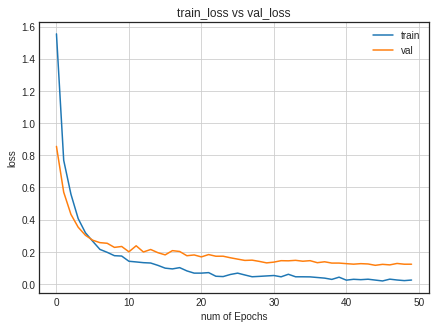

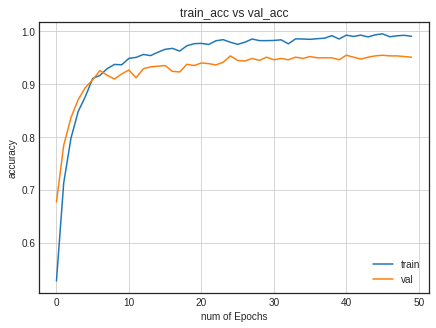

In [120]:
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['acc']
val_acc=history.history['val_acc']
xc=range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)

plt.show()

In [121]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics

target_pred = model.predict(input_test)
target_pred = np.argmax(target_pred, axis=1)

In [122]:
cm = confusion_matrix(target_test, target_pred)

print('\n\nModel Test Başarımı: ', model.evaluate(input_test, target_test))

33/33 [==============================] - 2s 51ms/step - loss: 0.1209 - acc: 0.9580


Model Test Başarımı:  [0.12093528360128403, 0.9580487608909607]


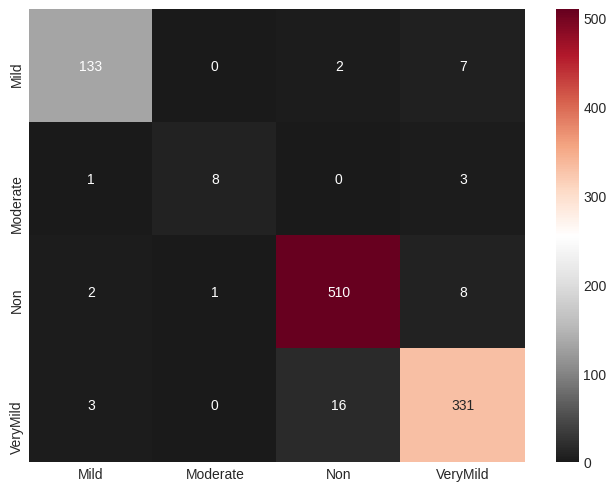

In [123]:
import seaborn as sns
df_cm = pd.DataFrame(cm, columns=["Mild", "Moderate", "Non", "VeryMild"], index=["Mild", "Moderate", "Non", "VeryMild"])
plt.figure(figsize=(8, 6), dpi=100)
sns.heatmap(df_cm, annot=True, cmap='RdGy_r', fmt='g');

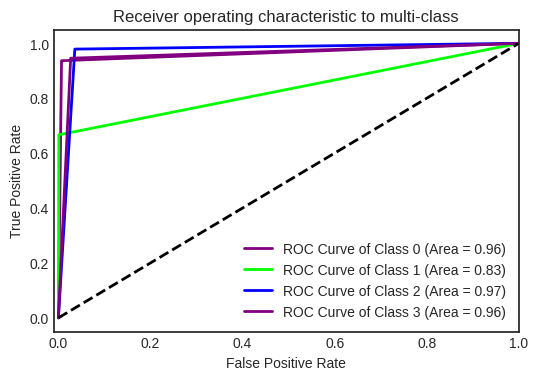

<Figure size 432x288 with 0 Axes>

In [124]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

plt.style.use("seaborn-white")
target_test_roc = label_binarize(target_test, classes=[0, 1, 2, 3])
target_pred_roc = label_binarize(target_pred, classes=[0, 1, 2 , 3])
n_classes = target_test_roc.shape[1]
# Plot linewidth.
lw = 2

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
   fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
   roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(dpi=100)
colors = cycle(['purple', 'lime', 'blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC Curve of Class {0} (Area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="best")
plt.show()
plt.savefig("resnet50_roc.png")

In [125]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm

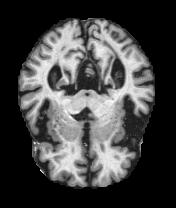

In [126]:
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions

model_builder = keras.applications.resnet50.ResNet50

img_size = (100, 100)

preprocess_input = preprocess_input
decode_predictions = decode_predictions



last_conv_layer_name = "conv5_block3_out"
classifier_layer_names = [
    "avg_pool",
    "predictions",
]


img_path = "./verymildDem23.jpg"

display(Image(img_path))

In [127]:
img_array = preprocess_input(get_img_array(img_path, size=img_size))

model = model_builder(weights="imagenet")

preds = model.predict(img_array)
print("Predicted:", decode_predictions(preds, top=1)[0])

heatmap = make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
)

Predicted: [('n04192698', 'shield', 0.74995714)]


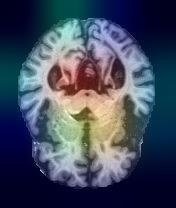

In [128]:
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

save_path = "sample1.jpg"
superimposed_img.save(save_path)

display(Image(save_path))

# **Sonuç**

***Alzheimer Veri Seti üzerinde, Model Basic, Model Branched olmak üzere iki model, transfer öğrenme olarakta ResNet50 modeli kullanılarak eğitimler gerçekleştirdim. Model Basic, 0.1062'lik bir kayıp ve 0.9736'lık bir başarı sağladı. Model Branched ise 0.0699'luk kayıp ve 0.9843'lük bir başarım ile en iyi sonuçları verdi. ResNet50 transfer learning modeli ise 0.1353'lük kayıp ve 0.9570'lik başarı sağladı. Bunun haricinde ResNet50 modeli üzerinde Grad-CAM yöntemi ile hastalığın bulunduğu bölgeyi tespit etmeye çalıştım. Öte yandan CLAHE (Contrast limited adaptive histogram equalization) ile verisetinin ön işlemesini yeniden gerçekleştirdikten sonra bu modellerin aynısını tekrar, ön işlenmiş veriler ile eğitip test ettim. Bu durumda Model Basic 0.0786'lık kayıp ve 0.9765'lik bir başarı sağladı. Model Branched ise 0.0578'lik kayıp ve 0.9814'lük başarı sağladı. Son olarak ResNet50 modeli ise, 0.1209'luk kayıp ve 0.9580'lik başarı elde etti. Görüldüğü üzere, imgelere CLAHE yöntemi uygulandıktan sonra kayıplar daha da düştü ve başarımlar daha da yükseldi.***